In [2]:
#%load_ext autoreload
#%autoreload 2

%pylab

import sys
# sys.path.append('./')
from utils_bosons import * 
# import gwaxion
# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from glob import glob
import parse
import collections
import math
from scipy import optimize

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'DejaVu Sans',
    'font.size': 24
    #'font.serif': 'Computer Modern Roman'
}
matplotlib.rcParams.update(mplparams)
matplotlib.rcParams['figure.figsize'] = 8, 4.5

cmap = 'magma'

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## Load PSDs

In [2]:
psd_path='/Users/richardbrito/Desktop/Projects/bosons_LISA_FoM/LISA_curves/S_h_{model}.txt'
psd_paths=glob(psd_path.format(model='*'))

psd_data={}

for path in psd_paths:
    label = parse.parse(psd_path, path)['model']
    psd_data[label] = np.loadtxt(path)
    
print(psd_data.keys())

dict_keys(['scird_deg2', 'scird_deg1', 'scird'])


## Load mass functions

In [3]:
data_path='/Users/richardbrito/Desktop/Projects/bosons_LISA_FoM/massfunctions/dnOverdAdLogM_z={redshift}.dat'
paths=glob(data_path.format(redshift='*'))

data_tmp = {}
data = {}

for path in np.sort(paths):
    label = parse.parse(data_path, path)['redshift']
    data_tmp[label] = np.loadtxt(path)
    redshift_col=np.full(len(data_tmp[label]), float(label))
    data[label] = np.column_stack((data_tmp[label], redshift_col))
    data_ord = collections.OrderedDict(data)
    
#put z=0 in first place and stack everything together, at the end columns should be:
#(0) log10M (1) spin (2) redshift (4) dn/(dlog10M dchi)
data_ord.move_to_end('0',last=False)
data_all=np.vstack(list(data_ord.values()))
data_all[:,[2, 3]]=data_all[:,[3, 2]]

## Waterfall plots

In [5]:
logMmin=4
logMmax=9
zmin=0.001
zmax=2

chi_bh=0.9
alpha=0.3
lgw=2

SNRarray=[]

for z in np.linspace(zmin,zmax, num=200):
    for log10mbh in np.linspace(logMmin, logMmax, num=50):


        cloud = physics.BosonCloud.from_parameters(1, 1, 0, alpha=alpha, m_bh=10**log10mbh, chi_bh=chi_bh, 
                                               evolve_params={'y_0': 1E-10})
       
        hgwr, fgw = cloud.gw(lgw).h0r, cloud.gw(lgw).f
        distance=cosmo.comoving_distance(z).value*1e6*physics.PC_SI
        h0=np.sqrt(5/(4*np.pi))*hgwr/distance #see notes
        hav=h0*np.sqrt(4/5) #see eq. 16 in https://arxiv.org/pdf/1803.01944.pdf
    
        fdetector=fgw/(1+z) #frequency at the detector
        tgw=cloud.get_life_time([lgw,lgw])
        tgwredshift=tgw*(1+z) #take into account cosmological redshift in duration of the signal
        
        SNR=SNRav(hav=hav, f=fdetector,PSD=psd_data['scird'], tgw=tgwredshift, Tobs = 4, gal=True)
        if SNR==0:
            SNR=1e-10 # this is to avoid errors when doing the waterfall plot
        
        SNRarray.append([log10mbh,z,SNR,hav])
        #print(log10mbh,z,SNRav(hav=hav, fdetector=fdetector, PSD=psd_data['scird'], tgw=tgw, Tobs = 4, gal=True))


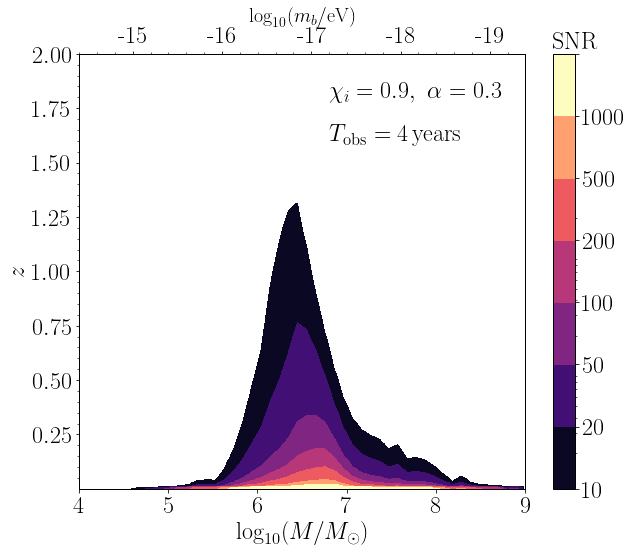

In [8]:
m_b=np.array([1e-15,1e-16,1e-17,1e-18,1e-19])
log10vec=np.vectorize(math.log10)
mass_list = np.array(SNRarray).T[0,:]
redshift_list = np.array(SNRarray).T[1,:]
snr_list = np.array(SNRarray).T[2,:]

rangec =[10,20,50,100,200,500,1000,50000]

fig, ax = plt.subplots(1, figsize=(10,8))
ax2 = ax.twiny()

CS = plt.tricontourf(mass_list, redshift_list, snr_list, 
                     levels=rangec,cmap='magma', origin='lower', vmin=10, vmax=2000, locator=ticker.LogLocator())
cb = plt.colorbar(CS, ticks=rangec)
cb.ax.set_yticklabels(['10', '20', '50','100','200','500','1000',''])  # vertically oriented colorbar
cb.set_label(label=r"SNR", labelpad=-50, y=1.05, rotation=0)

ax.set_xlabel(r"$\log_{10}(M/M_{\odot})$")
ax.set_ylabel(r"$z$")
ax.set_xlim([4,9])
plt.text(6.8, 1.8, r'$\chi_i=0.9,\,\,\alpha=0.3$')
plt.text(6.8, 1.6, r'$T_{\rm obs}=4\,{\rm years}$')

ax2.set_xlim(ax.get_xlim())
new_tick_locations = log10vec(alpha*physics.MPL_SI**2/(m_b*physics.EV_SI/physics.C_SI**2)/physics.MSUN_SI)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels([-15,-16,-17,-18,-19]) #(list(log10vec(m_b)))
ax2.set_xlabel(r'$\log_{10}(m_b/{\rm eV})$',fontsize=20)

plt.minorticks_on()

plot_file_name = './Plots/waterfall_LISA.pdf'
plt.savefig(plot_file_name, bbox_inches='tight')
plt.show()

In [9]:
SNRarray=[]

z=0.5

for log10mbh in np.linspace(logMmin, logMmax, num=50):

    cloud = physics.BosonCloud.from_parameters(1, 1, 0, alpha=alpha, m_bh=10**log10mbh, chi_bh=chi_bh, 
                                               evolve_params={'y_0': 1E-10})
    hgwr, fgw = cloud.gw(lgw).h0r, cloud.gw(lgw).f
    distance=cosmo.comoving_distance(z).value*1e6*physics.PC_SI
    h0=np.sqrt(5/(4*np.pi))*hgwr/distance #see notes
    hav=h0*np.sqrt(4/5) #see eq. 16 in https://arxiv.org/pdf/1803.01944.pdf
    
    fdetector=fgw/(1+z) #frequency at the detector
    tgw=cloud.get_life_time([lgw,lgw])
    tgwredshift=tgw*(1+z) #take into account cosmological redshift in duration of the signal
        
    SNR=SNRav(hav=hav, f=fdetector,PSD=psd_data['scird'], tgw=tgwredshift, Tobs = 4, gal=True)
    if SNR==0:
        SNR=1e-10 # this is to avoid errors when doing the waterfall plot
        
    SNRarray.append([log10mbh,SNR])

In [10]:
SNRcut=10
bounds = interpolate.interp1d(np.array(SNRarray)[:,0],np.array(SNRarray)[:,1]-SNRcut, kind='slinear')
SNRfunc = lambda x: bounds(x)

lower=optimize.newton(SNRfunc, 7.6)
upper=optimize.newton(SNRfunc, 5.5)

lowermb=alpha*physics.MPL_SI**2/(10**lower*physics.MSUN_SI)/(physics.EV_SI/physics.C_SI**2)
uppermb=alpha*physics.MPL_SI**2/(10**upper*physics.MSUN_SI)/(physics.EV_SI/physics.C_SI**2)

print("Detectable range is mb=[%.2e,%.2e]"%(lowermb,uppermb))

Detectable range is mb=[5.00e-18,4.44e-17]


## Compute stochastic background

In [126]:
logMmin=min(data_all[:,0])
#logMmax=max(data_all[:,0])
spinmin=0.0
spinmax=0.998
alphamax=0.5 #I set this because the maximum alpha=M*mb/Mpl**2 that gives instability for m=1 is alpha~0.5

OmegaGW_vs_mb={}

for bosonmass in np.logspace(-19, -15, num=20):
    
    logMmax=min(max(data_all[:,0]),
                math.log10(alphamax*physics.MPL_SI**2/(m_b*physics.EV_SI/physics.C_SI**2)/physics.MSUN_SI))
    
    lims=[[logMmin, logMmax], [spinmin, spinmax]]

    cloud = physics.BosonCloud.from_parameters(1, 1, 0, m_b=bosonmass, alpha=1e-3, chi_bh=0., evolve_params={'y_0': 1E-10}) 
    log10freqmax=math.log10(cloud.gw(2).f/(1+1e-3))
    log10freqmin=math.log10(cloud.gw(2).f/(1+7.))
    
    OmegaGW_vs_mb[bosonmass]=OmegaGW(dn=data_all,m_b=bosonmass,PSD=psd_data['scird'],intlims=lims,
                                     method='Riemann sum',nsumint=40j
                             ,log10freqmin=log10freqmin,log10freqmax=log10freqmax,num_f=30,printresults=False) 
    SNR=SNRback(OmegaGW_vs_mb[bosonmass],psd_data['scird'],limit=1000)
    
    print('mb=%.2e, SNR=%2.f, fmax=%.2e'%(bosonmass, SNR ,cloud.gw(2).f))


mb=1.00e-19, SNR= 2, fmax=4.84e-05
mb=1.62e-19, SNR= 9, fmax=7.85e-05
mb=2.64e-19, SNR=67, fmax=1.28e-04
mb=4.28e-19, SNR=159, fmax=2.07e-04


/Users/richardbrito/Desktop/Projects/bosons_LISA_FoM/utils_bosons.py:174: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  SNRsq_1s=integrate.quad(integrand, fmin, fmax,**kwargs)


mb=6.95e-19, SNR=538, fmax=3.36e-04


/Users/richardbrito/opt/anaconda3/lib/python3.8/site-packages/astropy/cosmology/core.py:1250: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  f = lambda z1, z2: quad(self._inv_efunc_scalar, z1, z2,
/Users/richardbrito/opt/anaconda3/lib/python3.8/site-packages/astropy/cosmology/core.py:1091: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  f = lambda red: quad(self._lookback_time_integrand_scalar, 0, red)[0]


mb=1.13e-18, SNR=2067, fmax=5.46e-04
mb=1.83e-18, SNR=5312, fmax=8.86e-04
mb=2.98e-18, SNR=16713, fmax=1.44e-03
mb=4.83e-18, SNR=53772, fmax=2.34e-03
mb=7.85e-18, SNR=56109, fmax=3.80e-03
mb=1.27e-17, SNR=58539, fmax=6.16e-03
mb=2.07e-17, SNR=36129, fmax=1.00e-02
mb=3.36e-17, SNR=13299, fmax=1.62e-02
mb=5.46e-17, SNR=4469, fmax=2.64e-02
mb=8.86e-17, SNR=1310, fmax=4.28e-02
mb=1.44e-16, SNR=313, fmax=6.96e-02
mb=2.34e-16, SNR=52, fmax=1.13e-01
mb=3.79e-16, SNR= 6, fmax=1.83e-01
mb=6.16e-16, SNR= 1, fmax=2.98e-01
mb=1.00e-15, SNR= 0, fmax=4.84e-01


In [127]:
SNRlist=[]

for m_b in OmegaGW_vs_mb.keys():

    SNR=SNRback(OmegaGW_vs_mb[m_b],psd_data['scird'],limit=1000,gal=False)
    SNRlist.append([m_b,SNR])
SNRarray=np.array(SNRlist)

Detectable range is m_b=[1.6e-19,3.6e-16]


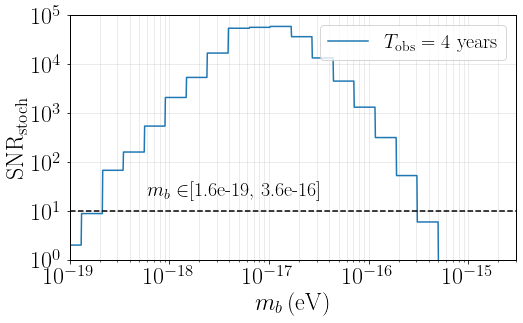

In [209]:
log10vec=np.vectorize(math.log10)

SNRcut=10
SNRint = interpolate.interp1d(-log10vec(SNRarray[:,0]),SNRarray[:,1]-SNRcut, kind='slinear')

SNRfunc = lambda x: SNRint(x)

lower=10**-optimize.newton(SNRfunc, 18)
upper=10**-optimize.newton(SNRfunc, 16)
print("Detectable range is m_b=[%.1e,%.1e]"%(lower,upper))

#plt.plot(SNRarray[:,0],SNRarray[:,1],'-',label=r'$T_{\rm obs}=4\,{\rm years}$')
SNRfunc = interpolate.interp1d(SNRarray[:,0],SNRarray[:,1], kind='nearest')
mbfunc = np.logspace(-19, -15, num=1000)
plt.plot(mbfunc,SNRfunc(mbfunc),'-',label=r'$T_{\rm obs} = 4\,\,{\rm years}$')

plt.ylim([1e0,1e5])
plt.xlim([1e-19,3e-15])

plt.yscale('log')
plt.xscale('log')
plt.xticks([1e-19,1e-18,1e-17,1e-16,1e-15])
plt.yticks([1e0,1e1,1e2,1e3,1e4,1e5])
plt.axhline(y=SNRcut,linestyle='--',c='black')

plt.legend(loc='upper right',fontsize=20)
plt.xlabel(r'$m_b\,({\rm eV})$')
plt.ylabel(r'${\rm SNR}_{\rm stoch}$')
#plt.text(5e-18, 24,r'${\rm SNR}>5$',size=15)
plt.text(6e-19, 20,'$m_b\in$[%.1e, %.1e]'%(lower,upper),size=20)

plt.grid(True, which='both', linestyle='-',alpha=0.3)
plt.minorticks_on()

plot_file_name = './Plots/SNR_background.pdf'
plt.savefig(plot_file_name, bbox_inches='tight')
plt.show()

## Compute number of CWs observations *with* confusion noise from stochastic background computed above

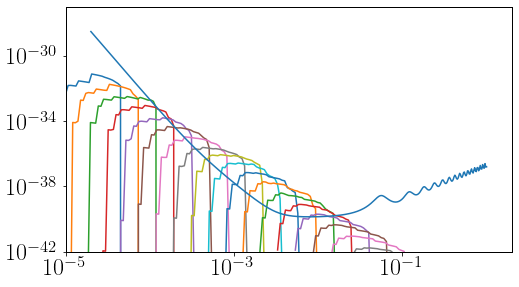

In [129]:
Sconf={}
for m_b in OmegaGW_vs_mb.keys():
    Sconf[m_b] = SfromOmegaGW(OmegaGW_vs_mb[m_b])
    plt.loglog(Sconf[m_b][:,0],Sconf[m_b][:,1])
plt.loglog(psd_data['scird'][:,0],psd_data['scird'][:,1])
plt.ylim([1e-42,1e-27])
plt.xlim([1e-5,2e-0])
plt.show()

In [130]:
Sn_mb={}
model='scird'
for m_b in Sconf.keys():
    Sn_total=[]
    Sn = interpolate.interp1d(psd_data[model][:,0],psd_data[model][:,1])
    Sconfint = interpolate.interp1d(Sconf[m_b][:,0],Sconf[m_b][:,1])
    
    fmin=min(Sconf[m_b][:,0])
    fmax=max(Sconf[m_b][:,0])
  
    for f in psd_data[model][:,0]:
        if f < fmin or f > fmax:
            Sn_total.append([f,Sn(f)])
        else:
            Sn_total.append([f,Sn(f)+Sconfint(f)])
    
    Sn_mb[m_b]=np.array(Sn_total)

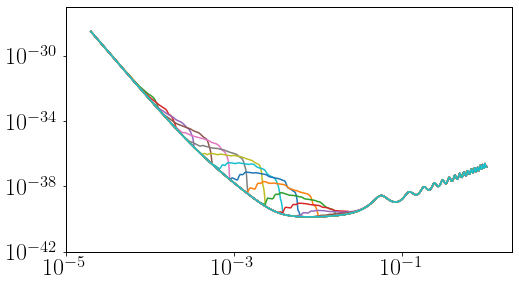

In [131]:
for m_b in OmegaGW_vs_mb.keys():
    plt.loglog(Sn_mb[m_b][:,0],Sn_mb[m_b][:,1])
plt.ylim([1e-42,1e-27])
plt.xlim([1e-5,2e-0])
plt.show()

In [183]:
Nvsmb=[]

#logMmin=4  #min(data_all[:,0])
#logMmax=9 #max(data_all[:,0])

#note that in priciple you can set whatever you want for int limits. 
#but narrowing the limits using some previous knowledge about detectable range 
#helps with decreasing the error of the integration

alphamin=0.01 #set by requiring instability timescale to be smaller than age of the Universe for all masses that we consider. 
alphamax=0.5 #set by maximum alpha=M*mb/Mpl**2 that gives instability for m=1
spinmin=0.0
spinmax=0.998
zmin=0.001
zmax=3 #max(data_all[:,2])

for m_b in Sn_mb.keys():
    logMmin=max(min(data_all[:,0]),
                math.log10(alphamin*physics.MPL_SI**2/(m_b*physics.EV_SI/physics.C_SI**2)/physics.MSUN_SI))
    logMmax=min(max(data_all[:,0]),
                math.log10(alphamax*physics.MPL_SI**2/(m_b*physics.EV_SI/physics.C_SI**2)/physics.MSUN_SI))

    lims=[[logMmin, logMmax], [spinmin, spinmax], [zmin, zmax]]
    
    Ntotal=Nevents(dn=data_all,m_b=m_b,PSD=Sn_mb[m_b],intlims=lims,neval=3e3,method='vegas',gal=True)
    Nvsmb.append([m_b,Ntotal])
    

mb=1.00e-19, Nevents=0.00, std=0.00, chisq/dof=0.00, Q=nan
mb=1.62e-19, Nevents=0.29, std=0.01, chisq/dof=3.46, Q=0.00
mb=2.64e-19, Nevents=1.66, std=0.07, chisq/dof=36.49, Q=0.00
mb=4.28e-19, Nevents=12.13, std=0.34, chisq/dof=1.98, Q=0.04
mb=6.95e-19, Nevents=24.23, std=0.45, chisq/dof=2.40, Q=0.01
mb=1.13e-18, Nevents=58.11, std=0.94, chisq/dof=1.01, Q=0.43
mb=1.83e-18, Nevents=86.47, std=1.98, chisq/dof=0.46, Q=0.90
mb=2.98e-18, Nevents=221.04, std=3.32, chisq/dof=0.61, Q=0.79
mb=4.83e-18, Nevents=1841.74, std=21.85, chisq/dof=0.91, Q=0.52
mb=7.85e-18, Nevents=4904.50, std=56.38, chisq/dof=1.82, Q=0.06
mb=1.27e-17, Nevents=6335.74, std=91.73, chisq/dof=0.78, Q=0.64
mb=2.07e-17, Nevents=3524.43, std=47.91, chisq/dof=1.71, Q=0.08
mb=3.36e-17, Nevents=3166.00, std=36.89, chisq/dof=1.56, Q=0.12
mb=5.46e-17, Nevents=2175.43, std=22.19, chisq/dof=0.93, Q=0.49
mb=8.86e-17, Nevents=551.57, std=5.39, chisq/dof=2.18, Q=0.02
mb=1.44e-16, Nevents=5.63, std=0.23, chisq/dof=7.23, Q=0.00
mb=2.34e

Detectable range is m_b=[2.1e-19,2.3e-16]


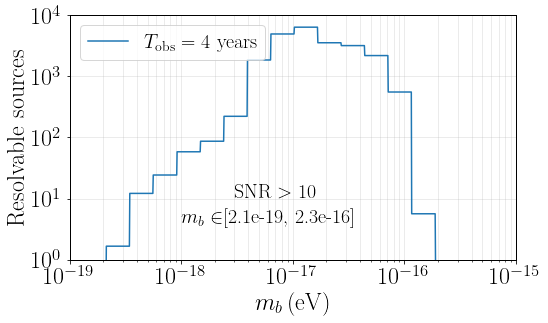

In [203]:
log10vec=np.vectorize(math.log10)
Narray=np.array(Nvsmb)

Ncut=1
Nroot = interpolate.interp1d(-log10vec(Narray[:,0]),Narray[:,1]-Ncut, kind='slinear')

Nrfunc = lambda x: Nroot(x)
mbfunc = np.logspace(-19, -15.5, num=1000)

lower=10**-optimize.newton(Nrfunc, 18)
upper=10**-optimize.newton(Nrfunc, 16)
print("Detectable range is m_b=[%.1e,%.1e]"%(lower,upper))

Nfunc = interpolate.interp1d(Narray[:,0],Narray[:,1], kind='nearest')
mbfunc = np.logspace(-19, -15.5, num=1000)

#plt.plot(Narray[:,0],Narray[:,1],'-',label=r'$T_{\rm obs}=4\,{\rm years}$')
plt.plot(mbfunc,Nfunc(mbfunc),'-',label=r'$T_{\rm obs} = 4\,\,{\rm years}$')

plt.ylim([1e0,1e4])
plt.xlim([1e-19,1e-15])

plt.yscale('log')
plt.xscale('log')
plt.xticks([1e-19,1e-18,1e-17,1e-16,1e-15])
plt.yticks([1e0,1e1,1e2,1e3,1e4])
#plt.axhline(y=1,linestyle='--',c='black')

plt.legend(loc='upper left',fontsize=20)
plt.xlabel(r'$m_b\,({\rm eV})$')
plt.ylabel(r'${\rm Resolvable\,\, sources}$')
plt.text(3e-18, 10,r'${\rm SNR}>10$',size=20)
plt.text(1e-18, 4,'$m_b\in$[%.1e, %.1e]'%(lower,upper),size=20)

plt.grid(True, which='both', linestyle='-',alpha=0.3)
plt.minorticks_on()

plot_file_name = './Plots/Nevents.pdf'
plt.savefig(plot_file_name, bbox_inches='tight')
plt.show()

## Compute number of CWs observations *without* confusion noise from stochastic background computed above


In [165]:
Nvsmb_noback=[]

alphamin=0.01
alphamax=0.5
spinmin=0.0
spinmax=0.998
zmin=0.001
zmax=3

for m_b in Sn_mb.keys():
    logMmin=max(min(data_all[:,0]),
                math.log10(alphamin*physics.MPL_SI**2/(m_b*physics.EV_SI/physics.C_SI**2)/physics.MSUN_SI))
    logMmax=min(max(data_all[:,0]),
                math.log10(alphamax*physics.MPL_SI**2/(m_b*physics.EV_SI/physics.C_SI**2)/physics.MSUN_SI))

    lims=[[logMmin, logMmax], [spinmin, spinmax], [zmin, zmax]]
    
    Ntotal=Nevents(dn=data_all,m_b=m_b,PSD=psd_data['scird'],intlims=lims,neval=2e3,method='vegas',gal=True)
    Nvsmb_noback.append([m_b,Ntotal])

./gwaxion/physics.py:264: RuntimeWarning: invalid value encountered in sqrt
  self.rp_natural = 1 + np.sqrt(1 - self.chi**2)
./gwaxion/physics.py:265: RuntimeWarning: invalid value encountered in sqrt
  self.rm_natural = 1 - np.sqrt(1 - self.chi**2)


mb=1.00e-19, Nevents=0.00, std=0.00, chisq/dof=26.04, Q=0.00
mb=1.62e-19, Nevents=0.27, std=0.01, chisq/dof=6.08, Q=0.00
mb=2.64e-19, Nevents=6.41, std=0.17, chisq/dof=2.51, Q=0.01
mb=4.28e-19, Nevents=21.12, std=0.56, chisq/dof=12.96, Q=0.00
mb=6.95e-19, Nevents=68.09, std=2.28, chisq/dof=0.73, Q=0.68
mb=1.13e-18, Nevents=140.50, std=4.35, chisq/dof=4.27, Q=0.00
mb=1.83e-18, Nevents=232.16, std=3.62, chisq/dof=1.64, Q=0.10
mb=2.98e-18, Nevents=1029.03, std=27.94, chisq/dof=7.36, Q=0.00
mb=4.83e-18, Nevents=21260.92, std=388.78, chisq/dof=0.56, Q=0.83
mb=7.85e-18, Nevents=108119.23, std=1972.17, chisq/dof=0.62, Q=0.78
mb=1.27e-17, Nevents=133818.54, std=1932.88, chisq/dof=0.92, Q=0.51
mb=2.07e-17, Nevents=75376.45, std=1118.05, chisq/dof=6.19, Q=0.00
mb=3.36e-17, Nevents=34789.36, std=357.76, chisq/dof=1.50, Q=0.14
mb=5.46e-17, Nevents=7479.65, std=85.06, chisq/dof=0.82, Q=0.60
mb=8.86e-17, Nevents=1044.63, std=11.71, chisq/dof=1.82, Q=0.06
mb=1.44e-16, Nevents=8.21, std=0.36, chisq/do

Detectable range is m_b=[1.7e-19,2.3e-16]


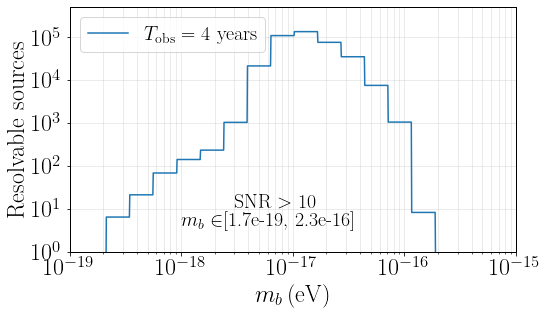

In [205]:
log10vec=np.vectorize(math.log10)
Narray_noback=np.array(Nvsmb_noback)

Ncut=1
Nroot = interpolate.interp1d(-log10vec(Narray_noback[:,0]),Narray_noback[:,1]-Ncut, kind='slinear')

Nrfunc = lambda x: Nroot(x)
mbfunc = np.logspace(-19, -15.5, num=1000)

lower=10**-optimize.newton(Nrfunc, 18)
upper=10**-optimize.newton(Nrfunc, 16)
print("Detectable range is m_b=[%.1e,%.1e]"%(lower,upper))

Nfunc_noback = interpolate.interp1d(Narray_noback[:,0],Narray_noback[:,1], kind='nearest')
mbfunc = np.logspace(-19, -15.5, num=1000)

#plt.plot(Narray[:,0],Narray[:,1],'-',label=r'$T_{\rm obs}=4\,{\rm years}$')
plt.plot(mbfunc,Nfunc_noback(mbfunc),'-',label=r'$T_{\rm obs} = 4\,\,{\rm years}$')

plt.ylim([1e0,5e5])
plt.xlim([1e-19,1e-15])

plt.yscale('log')
plt.xscale('log')
plt.xticks([1e-19,1e-18,1e-17,1e-16,1e-15])
plt.yticks([1e0,1e1,1e2,1e3,1e4,1e5])
#plt.axhline(y=1,linestyle='--',c='black')

plt.legend(loc='upper left',fontsize=20)
plt.xlabel(r'$m_b\,({\rm eV})$')
plt.ylabel(r'${\rm Resolvable\,\, sources}$')
plt.text(3e-18, 10,r'${\rm SNR}>10$',size=20)
plt.text(1e-18, 4,'$m_b\in$[%.1e, %.1e]'%(lower,upper),size=20)

plt.grid(True, which='both', linestyle='-',alpha=0.3)
plt.minorticks_on()

plot_file_name = './Plots/Nevents_noback.pdf'
plt.savefig(plot_file_name, bbox_inches='tight')
plt.show()

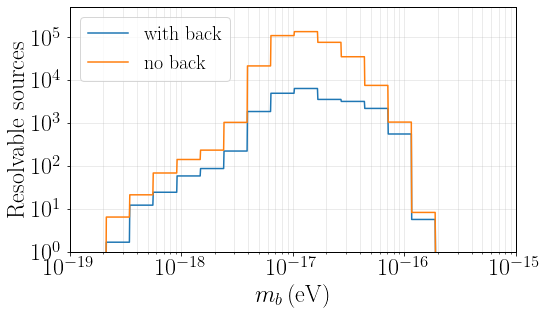

In [187]:
plt.plot(mbfunc,Nfunc(mbfunc),'-',label='with back')
plt.plot(mbfunc,Nfunc_noback(mbfunc),'-',label='no back')

plt.ylim([1e0,5e5])
plt.xlim([1e-19,1e-15])

plt.yscale('log')
plt.xscale('log')
plt.xticks([1e-19,1e-18,1e-17,1e-16,1e-15])
plt.yticks([1e0,1e1,1e2,1e3,1e4,1e5])
#plt.axhline(y=1,linestyle='--',c='black')

plt.legend(loc='upper left',fontsize=20)
plt.xlabel(r'$m_b\,({\rm eV})$')
plt.ylabel(r'${\rm Resolvable\,\, sources}$')
#plt.text(3e-18, 10,r'${\rm SNR}>10$',size=20)

plt.grid(True, which='both', linestyle='-',alpha=0.3)
plt.minorticks_on()

#plot_file_name = './Plots/Nevents_noback.pdf'
plt.savefig(plot_file_name, bbox_inches='tight')
plt.show()